In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [19]:
X= pd.read_csv('data/train.csv')
X=X.drop(X.columns[0],axis=1)


In [12]:
def sliding_window(X, window_size):
    X_windows = []
    y=[]
    for i in range(len(X)-window_size):
        X_windows.append(X[i:i+window_size])
        y.append(X[i+window_size])
    return np.array(X_windows),np.array(y)

In [55]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from tensorflow import keras

def create_model(learning_rate, depth, activation, units, window_size):

    inputs = keras.Input(shape=(window_size,))
    x = inputs

    for _ in range(depth):
        x = keras.layers.Dense(units=units, activation=activation)(x)

    outputs = keras.layers.Dense(units=1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    return model

best_score = float('inf')
final_params = {}
final_window_size = None
mse_scores = []
params_list=[]
# Assuming X is your dataset

learning_rates = [1e-5,0.001, 0.01, 1e-3]
depths = [1, 2, 3]
activations = ["relu"]
units = [16, 32, 64]

history_list = []

for window_size in range(1, 11):
    X_windows, y = sliding_window(X['Open'], window_size)
    X_train = pd.DataFrame(X_windows.reshape(-1, window_size))
    temp_best_score=float('inf')
    for lr in learning_rates:
        for d in depths:
            for act in activations:
                for u in units:
                    model = create_model(lr, d, act, u, window_size)
                    history = model.fit(X_train, y, epochs=3, verbose=0, validation_split=0.2)  # Training with validation split
                    history_list.append(history)
                    mse = model.evaluate(X_train, y, verbose=0)
                    if mse < temp_best_score:
                        temp_best_score=mse
                    params_list.append({'learning_rate': lr, 'depth': d, 'activation': act, 'units': u, 'window_size': window_size})
                    if mse < best_score:
                        best_score = mse
                        final_window_size = window_size
                        final_params = {'learning_rate': lr, 'depth': d, 'activation': act, 'units': u,'window_size':window_size}
    mse_scores.append(temp_best_score)

X_windows, y = sliding_window(X['Open'], final_window_size)
X_train = pd.DataFrame(X_windows.reshape(-1, final_window_size))
final_model = create_model(**final_params)
final_model.fit(X_train, y)

print("Best window size:", final_window_size)
print("Best hyperparameters:", final_params)
print("Best error:", best_score)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.0090 
Best window size: 1
Best hyperparameters: {'learning_rate': 0.01, 'depth': 1, 'activation': 'relu', 'units': 64, 'window_size': 1}
Best error: 0.00012025182513752952


In [56]:
test_data=pd.read_csv('data/val.csv')
test_data

,Unnamed: 0,Open
0,1819,0.396632
1,1820,0.398211
2,1821,0.391579
3,1822,0.390632
4,1823,0.400737
...,...,...
385,2204,0.514947
386,2205,0.509263
387,2206,0.505895
388,2207,0.511158


In [57]:
test_X_windows,y_test = sliding_window(test_data['Open'], final_window_size)
test_X_windows = pd.DataFrame(test_X_windows.reshape(-1,final_window_size))
test_X_windows
print(y_test)

[0.39821053 0.39157895 0.39063158 0.40073684 0.39894737 0.39052632
 0.39536842 0.38157895 0.38894737 0.392      0.39757895 0.39873684
 0.40115789 0.41084211 0.40757895 0.41936842 0.42021053 0.41136842
 0.422      0.42421053 0.41821053 0.42652632 0.42452632 0.428
 0.42589474 0.42915789 0.42684211 0.42631579 0.42431579 0.436
 0.44642105 0.43989474 0.43105263 0.43463158 0.44536842 0.42768421
 0.41915789 0.43231579 0.43315789 0.46726316 0.47431579 0.47136842
 0.46157895 0.46957895 0.47410526 0.48010526 0.47905263 0.51936842
 0.48684211 0.49189474 0.48863158 0.48368421 0.48052632 0.46915789
 0.45978947 0.44852632 0.45273684 0.47052632 0.46052632 0.46884211
 0.46378947 0.45968421 0.46915789 0.46178947 0.44778947 0.44821053
 0.46010526 0.45726316 0.45126316 0.44536842 0.444      0.45063158
 0.45452632 0.45778947 0.45021053 0.44978947 0.46368421 0.48210526
 0.47905263 0.48368421 0.47389474 0.47484211 0.46884211 0.46347368
 0.46778947 0.44168421 0.45294737 0.45505263 0.45273684 0.44768421
 0.43

In [58]:
test_y_pred = (final_model.predict(test_X_windows))
test_y_pred.shape,y_test.shape

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


((389, 1), (389,))

In [59]:
test_y_pred = test_y_pred.flatten()
y_test = y_test.flatten()
mse = mean_squared_error(y_test, test_y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.0004511116653516584


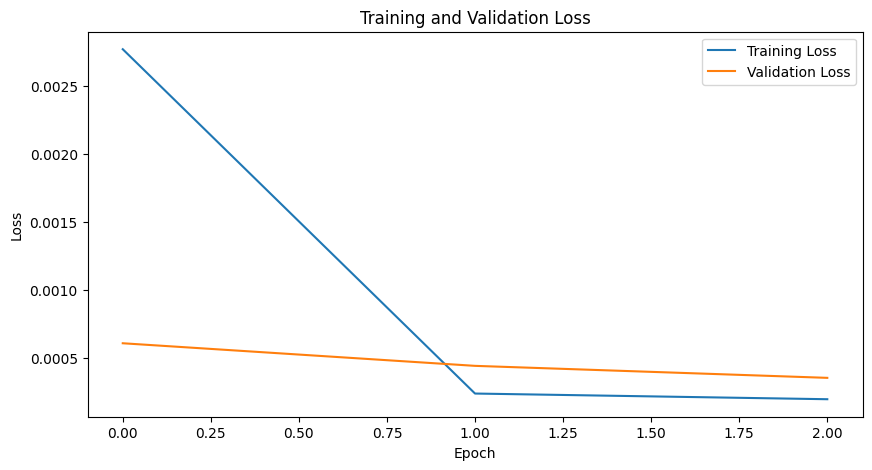

In [60]:
X_test_windows, y_test = sliding_window(X['Open'], final_window_size)
X_test = pd.DataFrame(X_test_windows.reshape(-1, final_window_size))

# 1. Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


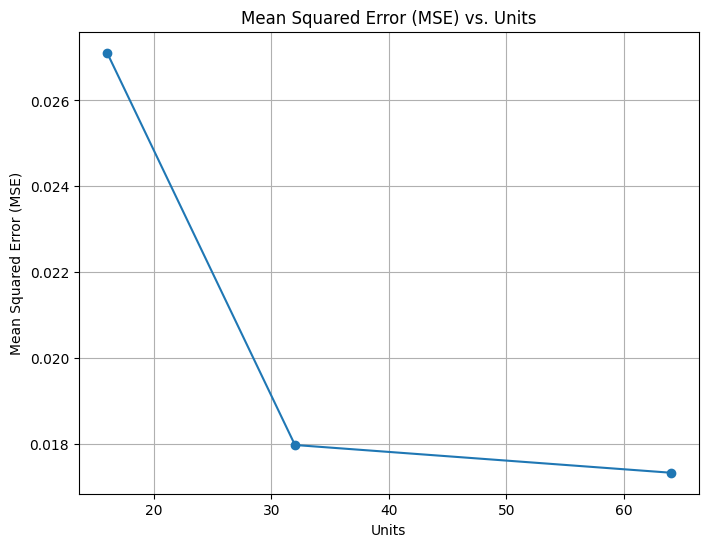

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean MSE for each unit value
mse_means = []
for u in units:
    mse_values_u = [mse for mse, params in zip(mse_scores, params_list) if params['units'] == u]
    mse_means.append(np.mean(mse_values_u) if mse_values_u else np.nan)

# Plotting MSE vs. Units
plt.figure(figsize=(8, 6))
plt.plot(units, mse_means, marker='o')
plt.title('Mean Squared Error (MSE) vs. Units')
plt.xlabel('Units')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()


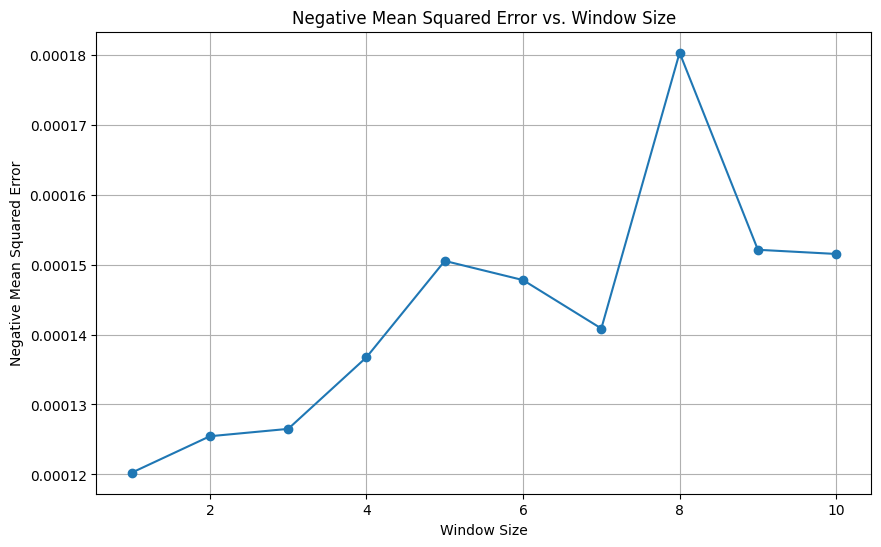

In [61]:
import matplotlib.pyplot as plt
window_sizes = list(range(1, 11))
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, mse_scores, marker='o')
plt.title('Negative Mean Squared Error vs. Window Size')
plt.xlabel('Window Size')
plt.ylabel('Negative Mean Squared Error')
plt.grid(True)
plt.show()

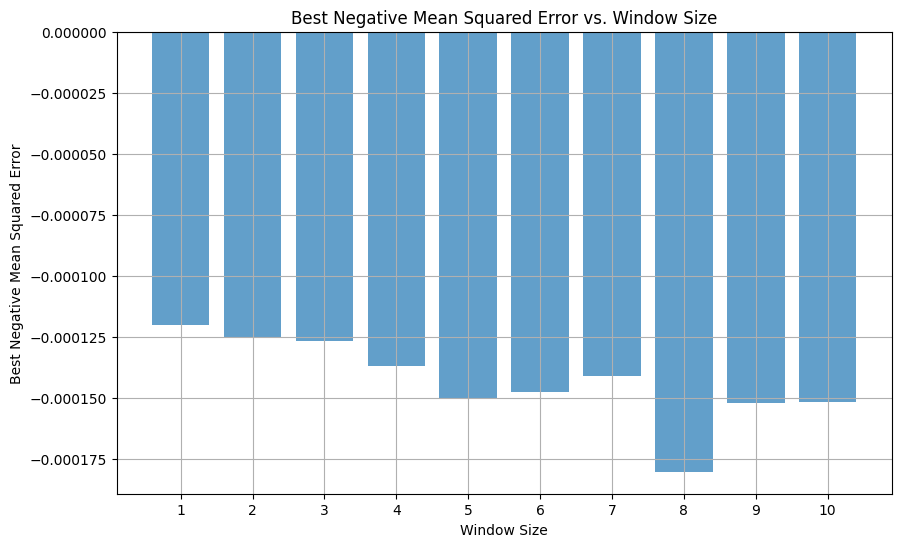

In [62]:
plt.figure(figsize=(10, 6))
plt.bar(window_sizes, [-mse for mse in mse_scores], align='center', alpha=0.7)
plt.title('Best Negative Mean Squared Error vs. Window Size')
plt.xlabel('Window Size')
plt.ylabel('Best Negative Mean Squared Error')
plt.xticks(window_sizes)
plt.grid(True)
plt.show()